<a href="https://colab.research.google.com/github/Bone-Age-Maisha/paper_1/blob/main/Pytorch_age1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [48]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [49]:
import tensorflow as tf
import tensorflow_datasets as tfds
import numpy as np
import matplotlib.pyplot as plt

In [50]:
gpus = tf.config.experimental.list_physical_devices('GPU')
tf.config.experimental.set_visible_devices(gpus[0], 'GPU')
tf.config.experimental.set_memory_growth(gpus[0], True)

In [51]:
from google.colab import drive
drive.mount('/content/gdrive')



Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [52]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-

import torch
import torch.nn as nn

def conv3x3(in_planes, out_planes, stride=1):
    """3x3 convolution with padding"""
    return nn.Conv2d(in_planes, out_planes, kernel_size=3, stride=stride,
                     padding=1, bias=False)



#%%
# Bottleneck block for ResNet to reduce dimensions
class Bottleneck(nn.Module):
    expansion = 4

    def __init__(self, inplanes, planes, stride=1, downsample=None):
        super(Bottleneck, self).__init__()
        self.conv1 = nn.Conv2d(inplanes, planes, kernel_size=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3, stride=stride,
                               padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)
        self.conv3 = nn.Conv2d(planes, planes * self.expansion, kernel_size=1, bias=False)
        self.bn3 = nn.BatchNorm2d(planes * self.expansion)
        self.relu = nn.ReLU(inplace=True)
        self.downsample = downsample
        self.stride = stride

    def forward(self, x):
        residual = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)
        out = self.relu(out)

        out = self.conv3(out)
        out = self.bn3(out)

        if self.downsample is not None:
            residual = self.downsample(x)

        out += residual
        out = self.relu(out)

        return out
#%%
# Custom Convolution Neural Network architecture based on ResNet
class AgePredictor(nn.Module):
    
    # Define and Initialize Layers
    def __init__(self, block, layers, num_classes=1000):
        self.inplanes = 64
        super(AgePredictor, self).__init__()
        # ResNet Architecture
        self.conv1 = nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3,  # <-
                               bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        self.layer1 = self._make_layer(block, 64, layers[0])
        self.layer2 = self._make_layer(block, 128, layers[1], stride=2)
        self.layer3 = self._make_layer(block, 256, layers[2], stride=2)
        self.layer4 = self._make_layer(block, 512, layers[3], stride=2)
        self.avgpool = nn.AdaptiveAvgPool2d(1)                          # <-       
        self.fc = nn.Linear(512 * block.expansion, 400)
        self.res_relu = nn.ReLU()
        
        
        # Fully Connected layer for gender
        self.gen_fc_1 = nn.Linear(1,16)
        self.gen_relu = nn.ReLU()
        
        # Feature Concatenation Layer
        self.cat_fc = nn.Linear(16+400,200)
        self.cat_relu = nn.ReLU()
        
        # Final Fully Connected Layer
        self.final_fc = nn.Linear(200,num_classes)
        
        # Simply using linear layer (w/o sigmoid) led to network predicting negative values for age
        # Therefore input was scaled to range from 0 and 1
        # and sigmoid is used as final layer to predict values which when 
        # denormalized led to positive values
        self.sigmoid = nn.Sigmoid()
        
        # Weight Initialization 
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)

    def _make_layer(self, block, planes, blocks, stride=1):
        downsample = None
        if stride != 1 or self.inplanes != planes * block.expansion:
            downsample = nn.Sequential(
                nn.Conv2d(self.inplanes, planes * block.expansion,
                          kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(planes * block.expansion),
            )

        layers = []
        layers.append(block(self.inplanes, planes, stride, downsample))
        self.inplanes = planes * block.expansion
        for i in range(1, blocks):
            layers.append(block(self.inplanes, planes))

        return nn.Sequential(*layers)

    # Forward Pass. x = Image tensor, y = gender tensor
    def forward(self, x,y):
# =============================================================================
#       ResNet Layers        
# =============================================================================
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)

        x = self.avgpool(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        x = self.res_relu(x)
        x = x.view(x.size(0), -1)
        

# =============================================================================
#       Gender Fully Connected Layer
# =============================================================================
        y = self.gen_fc_1(y)
        y = self.gen_relu(y)
        y = y.view(y.size(0), -1)

        
# =============================================================================
#       Feature Concatenation Layer
# =============================================================================
      
        z = torch.cat((x,y),dim = 1)
        z = self.cat_fc(z)
        z = self.cat_relu(z)

# =============================================================================
#       Final FC Layer
# =============================================================================
        
        z = self.final_fc(z)
        z = self.sigmoid(z)

        return z








In [53]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
from torchvision import transforms
import os
#os.chdir('/home/kneehit/Data Science/Bone Age Kaggle/PyTorch')
from torch.utils.data import Dataset, DataLoader
import cv2
import pandas as pd
import glob
import random

In [54]:
train_dataset_path = '/content/gdrive/MyDrive/small_data/train/*'
csv_path = '/content/gdrive/MyDrive/small_data/train_csv1.csv'
val_dataset_path = '/content/gdrive/MyDrive/small_data/val/*'
val_path = '/content/gdrive/MyDrive/small_data/val_csv.csv'

In [55]:
torch.manual_seed(1498920)
np.random.seed(1498920)
random.seed(1498920)



In [56]:
 #print(train_dataset_path)
#k = 71
k=10
size = 500
image_filenames = glob.glob(train_dataset_path)
#image_filenames
#random_images = random.sample(population = image_filenames,k = k)

In [57]:
#k = 10
#k=10
size = 500
val_filenames = glob.glob(val_dataset_path)
#image_filenames
#random_val = random.sample(population = val_filenames,k = k)

In [58]:
len(image_filenames)

71

In [59]:
len(val_filenames)

23

In [60]:
means = []
stds = []
pl=1
#for filename in random_images:
for filename in image_filenames:
    image = cv2.imread(filename,0)
    image = cv2.resize(image,(size,size))
    mean,std = cv2.meanStdDev(image)
#    mean /= 255
#    std /= 255
    print(pl)
    pl=pl+1
    means.append(mean[0][0])
    stds.append(std[0][0])

avg_mean = np.mean(means) 
avg_std = np.mean(stds)

print('Approx. Mean of Images in Dataset: ',avg_mean)
print('Approx. Standard Deviation of Images in Dataset: ',avg_std)


1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
Approx. Mean of Images in Dataset:  122.1892254647887
Approx. Standard Deviation of Images in Dataset:  27.119624660799772


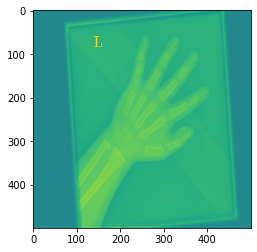

In [61]:
plt.imshow(image)

In [62]:
dataset_size = len(image_filenames)
#dataset_size=dataset_size-10
val_size =23

In [63]:
means1 = []
stds1 = []
cn=1

#for filename in random_val:
for filename in val_filenames:
    print(filename)
    image1 = cv2.imread(filename,0)
    image1 = cv2.resize(image1,(size,size))
    mean,std = cv2.meanStdDev(image1)
    print(cn)
    cn=cn+1
#    mean /= 255
#    std /= 255
    
    means1.append(mean[0][0])
    stds1.append(std[0][0])


/content/gdrive/MyDrive/small_data/val/1589.png
1
/content/gdrive/MyDrive/small_data/val/1584.png
2
/content/gdrive/MyDrive/small_data/val/1587.png
3
/content/gdrive/MyDrive/small_data/val/1582.png
4
/content/gdrive/MyDrive/small_data/val/1586.png
5
/content/gdrive/MyDrive/small_data/val/1585.png
6
/content/gdrive/MyDrive/small_data/val/1592.png
7
/content/gdrive/MyDrive/small_data/val/1590.png
8
/content/gdrive/MyDrive/small_data/val/1588.png
9
/content/gdrive/MyDrive/small_data/val/1591.png
10
/content/gdrive/MyDrive/small_data/val/1593.png
11
/content/gdrive/MyDrive/small_data/val/1594.png
12
/content/gdrive/MyDrive/small_data/val/1595.png
13
/content/gdrive/MyDrive/small_data/val/1600.png
14
/content/gdrive/MyDrive/small_data/val/1596.png
15
/content/gdrive/MyDrive/small_data/val/1598.png
16
/content/gdrive/MyDrive/small_data/val/1602.png
17
/content/gdrive/MyDrive/small_data/val/1601.png
18
/content/gdrive/MyDrive/small_data/val/1605.png
19
/content/gdrive/MyDrive/small_data/val/1

72


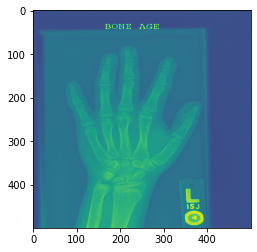

In [64]:
print(pl)
plt.imshow(image1)

In [65]:
bones_df = pd.read_csv(csv_path)
bones_df.iloc[:,1:3] = bones_df.iloc[:,1:3].astype(np.float)

val_df = pd.read_csv(val_path)
val_df.iloc[:,1:3] = val_df.iloc[:,1:3].astype(np.float)

train_df = bones_df.iloc[:dataset_size,:]
val_df = val_df.iloc[:val_size,:]

age_max = np.max(bones_df['boneage'])
age_min = np.min(bones_df['boneage'])
print(age_max)
print(age_min)

192.0
4.0


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  """


In [66]:
val_df

,id,boneage,male
0,1582,72.0,1.0
1,1584,94.0,0.0
2,1585,144.0,0.0
3,1586,36.0,0.0
4,1587,138.0,1.0
5,1588,82.0,0.0
6,1589,192.0,1.0
7,1590,33.0,0.0
8,1591,156.0,1.0
9,1592,39.0,0.0


In [67]:
train_df

,id,boneage,male
0,1377,180.0,0.0
1,1378,12.0,0.0
2,1379,94.0,0.0
3,1380,120.0,1.0
4,1381,82.0,0.0
...,...,...,...
66,1452,180.0,0.0
67,1453,192.0,1.0
68,1454,21.0,0.0
69,1455,32.0,1.0


In [85]:
class BonesDataset(Dataset):
    def __init__(self, dataframe, image_dir, transform=None):

        self.dataframe = dataframe

        
        self.image_dir = image_dir
        self.transform = transform
        

    def __len__(self):
        return self.dataframe.shape[0]

    def __getitem__(self, idx):
        img_name = self.image_dir + str(self.dataframe.iloc[idx,0]) + '.png'
        #print(img_name)
        image = cv2.imread(img_name,0)
        #plt.imshow(image)
        image = image.astype(np.float64)
        gender = np.atleast_1d(self.dataframe.iloc[idx,2])
        bone_age = np.atleast_1d(self.dataframe.iloc[idx,1])
        
        

        sample = {'image': image, 'gender': gender, 'bone_age':bone_age}

        if self.transform:
            sample = self.transform(sample)

        return sample

In [86]:
class ToTensor(object):
   def __call__(self, sample):
        image, gender, bone_age = sample['image'], sample['gender'], sample['bone_age']


        image = cv2.resize(image,(size,size))
        image = np.expand_dims(image,axis = 0)
        
#       we need to convert  cuda.longtensors to cuda.floatTensor data type
        return {'image': torch.from_numpy(image).float(),
                'gender': torch.from_numpy(gender).float(),
                'bone_age':torch.from_numpy(bone_age).float()}        


In [87]:
# Normalize images and bone age
class Normalize(object):
    
    def __init__(self,img_mean,img_std,age_min,age_max):
        self.mean = mean
        self.std = std
        
        self.age_min = age_min
        self.age_max = age_max
        
    
    
    def __call__(self,sample):
        image, gender, bone_age = sample['image'], sample['gender'], sample['bone_age']
        
        image -= self.mean
        image /= self.std
        
        bone_age = (bone_age - self.age_min)/ (self.age_max - self.age_min)
        
        
        
        return {'image': image,
                'gender': gender,
                'bone_age':bone_age} 
        


data_transform = transforms.Compose([
   Normalize(avg_mean,avg_std,age_min,age_max),
   ToTensor()
   
   ])     
    

In [88]:
train_path='/content/gdrive/MyDrive/small_data/train/'
vald_path='/content/gdrive/MyDrive/small_data/val/'
train_dataset = BonesDataset(dataframe = train_df,image_dir=train_path,transform = data_transform)
print("  ***************valid********************")
val_dataset = BonesDataset(dataframe = val_df,image_dir = vald_path,transform = data_transform)

  ***************valid********************


In [89]:
val_dataset

In [90]:
train_dataset

In [91]:
train_data_loader = DataLoader(train_dataset,batch_size=1,shuffle=False,num_workers = 2)
val_data_loader = DataLoader(val_dataset,batch_size=1,shuffle=False,num_workers = 2)

In [92]:
t=1
for batch_no,batch in enumerate(train_data_loader):
  print(t)
  print(batch)
  t=t+1
 

1
{'image': tensor([[[[ 4.0732,  4.0579,  4.2017,  ..., -0.7463, -0.7797, -0.7444],
          [ 4.1500,  4.2248,  4.3040,  ..., -0.8136, -0.9336, -0.9303],
          [ 4.0058,  4.0552,  4.1833,  ..., -0.9094, -0.8410, -0.8166],
          ...,
          [ 3.8368,  3.7563,  3.8661,  ..., -1.5484, -1.5388, -1.6527],
          [ 3.5969,  3.4981,  3.5890,  ..., -1.5829, -1.5496, -1.6102],
          [ 3.7819,  3.6997,  3.6749,  ..., -1.4801, -1.4927, -1.6335]]]]), 'gender': tensor([[0.]]), 'bone_age': tensor([[0.9362]])}
2
{'image': tensor([[[[0.8354, 0.7922, 0.8508,  ..., 0.8075, 0.7787, 0.8191],
          [0.8241, 0.8363, 0.8142,  ..., 0.7970, 0.7957, 0.8055],
          [0.7936, 0.8537, 0.8221,  ..., 0.8221, 0.8716, 0.8221],
          ...,
          [0.7646, 0.8522, 0.8448,  ..., 0.7620, 0.8912, 0.8640],
          [0.8169, 0.8276, 0.8069,  ..., 0.8198, 0.8351, 0.8244],
          [0.8533, 0.9082, 0.8629,  ..., 0.8043, 0.8067, 0.8060]]]]), 'gender': tensor([[0.]]), 'bone_age': tensor([[0.042

In [93]:
t=1
for batch_no,batch in enumerate(val_data_loader):
  print(t)
  print(batch)
  t=t+1
 

1
{'image': tensor([[[[-2.4987, -2.4601, -2.4973,  ..., -2.5946, -2.5798, -2.5085],
          [-2.5187, -2.4644, -2.5464,  ..., -2.5828, -2.5335, -2.5919],
          [-2.4506, -2.4110, -2.5040,  ..., -2.4686, -2.5628, -2.5110],
          ...,
          [-2.4426, -2.5211, -2.3817,  ..., -2.4843, -2.4153, -2.5482],
          [-2.4821, -2.5274, -2.4571,  ..., -2.4853, -2.5333, -2.5116],
          [-2.4829, -2.4061, -2.4094,  ..., -2.4989, -2.5208, -2.5029]]]]), 'gender': tensor([[1.]]), 'bone_age': tensor([[0.3617]])}
2
{'image': tensor([[[[0.6312, 0.6255, 0.5968,  ..., 0.5737, 0.6428, 0.5994],
          [0.6318, 0.6469, 0.6119,  ..., 0.6460, 0.6217, 0.5993],
          [0.5787, 0.6569, 0.5615,  ..., 0.5971, 0.6454, 0.6576],
          ...,
          [0.5985, 0.5902, 0.5971,  ..., 0.5369, 0.5862, 0.5783],
          [0.5696, 0.6170, 0.6152,  ..., 0.6388, 0.6291, 0.6678],
          [0.6255, 0.5833, 0.5832,  ..., 0.6287, 0.6845, 0.6283]]]]), 'gender': tensor([[0.]]), 'bone_age': tensor([[0.478

In [94]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
age_predictor = AgePredictor(block = Bottleneck,layers = [3, 4, 23, 3],num_classes =1)


#%%
# Set loss as mean squared error (for continuous output)
# Initialize Stochastic Gradient Descent optimizer and learning rate scheduler

age_predictor = age_predictor.to(device)
criterion = nn.MSELoss()
optimizer = optim.SGD(age_predictor.parameters(), lr=0.001, momentum=0.9)
scheduler = lr_scheduler.StepLR(optimizer, step_size=12, gamma=0.5)

In [95]:
def denormalize(inputs,age_min,age_max):
    return inputs * (age_max - age_min) + age_min

In [96]:
def save_checkpoint(state, filename='checkpoint.pth.tar'):
    torch.save(state, filename)


def eval_model(model,data_loader):
    model.eval()

    with torch.no_grad():
        
        result_array = np.array([])
        
        for batch_no,batch in enumerate(data_loader):
            
            optimizer.zero_grad()
            
            image = batch['image'].to(device)
            gender = batch['gender'].to(device)
            
    
            outputs = model(image,gender)
            preds = outputs.cpu().numpy()
    
            preds = preds.reshape(preds.shape[0])
            preds = denormalize(preds,age_min,age_max)
            
            result_array = np.concatenate((result_array,preds))
            
        return result_array

In [100]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=2):
    
    for epoch in range(num_epochs):
        scheduler.step()
        model.train()
        running_loss = 0.0
        val_running_loss = 0.0
        
        for batch_no,batch in enumerate(train_data_loader):
            # Load batch
            image = batch['image'].to(device)
            gender = batch['gender'].to(device)
            age = batch['bone_age'].to(device)

            
            optimizer.zero_grad()
            
            with torch.set_grad_enabled(True):
                # Forward Pass
                outputs = model(image,gender)
                loss = criterion(outputs, age)
                
                # Backprop
                loss.backward()
                optimizer.step()
                
            # Calculate Loss
            running_loss += loss.item() * image.size(0)
            
            if (batch_no + 1) % 71 == 0: print('Epoch {} Batch {}/2500 '.format(epoch+1,batch_no+1))
            
        #total_loss = running_loss / dataset_size
        total_loss = running_loss
        print('\n \n Epoch {} Loss: {:.4f} \n \n'.format(epoch+1,total_loss))
        
        
    # Eval on validation set
    model.eval()
    for val_batch in val_data_loader:
        image = val_batch['image'].to(device)
        gender = val_batch['gender'].to(device)
        age = val_batch['bone_age'].to(device)

        
        optimizer.zero_grad()  
        # only forward pass, dont update gradients
        with torch.set_grad_enabled(False):
            outputs = model(image,gender)
            loss = criterion(outputs, age)
            
        val_running_loss += loss.item() * image.size(0)
    
    #val_loss = val_running_loss / 23
    val_loss = val_running_loss 
    
    print('Validation Loss {:.4f}'.format(val_loss))

    total_epochs = scheduler.state_dict()['last_epoch'] + 1        
    states = {
            'epoch': total_epochs + 1,
            'state_dict': model.state_dict(),
            'optimizer' : optimizer.state_dict(),
            'scheduler'  : scheduler.state_dict()
        }
    save_checkpoint(states,filename = 'epoch-{}-loss-{:.4f}-val_loss-{:.4f}.pth.tar'.format(total_epochs,total_loss,val_loss))

    return model
    #/content/gdrive/MyDrive/small_data/val/1582.png

In [101]:
resnet_model = train_model(age_predictor,criterion,optimizer,scheduler,num_epochs=20)

Epoch 1 Batch 71/2500 

 
 Epoch 1 Loss: 5.8998 
 

Epoch 2 Batch 71/2500 

 
 Epoch 2 Loss: 5.8849 
 

Epoch 3 Batch 71/2500 

 
 Epoch 3 Loss: 5.8826 
 

Epoch 4 Batch 71/2500 

 
 Epoch 4 Loss: 5.8816 
 

Epoch 5 Batch 71/2500 

 
 Epoch 5 Loss: 5.8826 
 

Epoch 6 Batch 71/2500 

 
 Epoch 6 Loss: 5.8815 
 

Epoch 7 Batch 71/2500 

 
 Epoch 7 Loss: 5.8837 
 

Epoch 8 Batch 71/2500 

 
 Epoch 8 Loss: 5.8796 
 

Epoch 9 Batch 71/2500 

 
 Epoch 9 Loss: 5.8822 
 

Epoch 10 Batch 71/2500 

 
 Epoch 10 Loss: 5.8805 
 

Epoch 11 Batch 71/2500 

 
 Epoch 11 Loss: 5.8780 
 

Epoch 12 Batch 71/2500 

 
 Epoch 12 Loss: 5.8792 
 

Epoch 13 Batch 71/2500 

 
 Epoch 13 Loss: 5.8789 
 

Epoch 14 Batch 71/2500 

 
 Epoch 14 Loss: 5.8681 
 

Epoch 15 Batch 71/2500 

 
 Epoch 15 Loss: 5.8706 
 

Epoch 16 Batch 71/2500 

 
 Epoch 16 Loss: 5.8680 
 

Epoch 17 Batch 71/2500 

 
 Epoch 17 Loss: 5.8647 
 

Epoch 18 Batch 71/2500 

 
 Epoch 18 Loss: 5.8647 
 

Epoch 19 Batch 71/2500 

 
 Epoch 19 Loss: 5.8